![picture](https://drive.google.com/uc?export=view&id=1RgB_1hRKixwGPs9YygTiddlVWEQynFpj)

In [0]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
use_cuda  = torch.cuda.is_available()

In [3]:
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 800, 5)
        self.conv4 = nn.Conv2d(800, 800, 1)
        self.conv5 = nn.Conv2d(800, 10, 1)
        self.pool = nn.MaxPool2d((2,2))
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x
        

In [0]:
model = Model()
if use_cuda:
    model = model.cuda()

In [0]:
def train_model(model, train_loader, test_loader, n_epochs):
    
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    min_test_accuracy = 0
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        train_accuracy = 0
        test_accuracy = 0
        ###################
        # train the model #
        ###################
        model.train()
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(images).squeeze()
            _, outs_k = logits.topk(1, dim=1)
            equals = (outs_k == labels.view(*outs_k.shape))
            train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # calculate the batch loss
            loss = criterion(logits, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()


        train_loss = train_loss/len(train_loader)
        train_accuracy /= len(train_loader)
        ######################
        # validate the model #
        ######################
        model.eval()
        for images, labels in test_loader:
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            logits = model(images).squeeze()
            _, outs_k = logits.topk(1, dim=1)
            equals = (outs_k == labels.view(*outs_k.shape))
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        test_accuracy /= len(test_loader)
        print("""Epoch: {} \tTraining Loss: {:.6f} 
        \tTrain accuracy: {:.6f} \Test accuracy: {:.6f}""".format(
            epoch, train_loss,  train_accuracy, test_accuracy))
    
        # save model if validation accuracy has increased
        if test_accuracy >= min_test_accuracy:    
            torch.save(model.state_dict(), 'model.pt')
            min_test_accuracy = test_accuracy

In [8]:
train_model(model, train_loader, test_loader, 5)

Epoch: 1 	Training Loss: 0.061145 
        	Train accuracy: 0.982783 \Test accuracy: 0.985000
Epoch: 2 	Training Loss: 0.042098 
        	Train accuracy: 0.987867 \Test accuracy: 0.989100
Epoch: 3 	Training Loss: 0.033079 
        	Train accuracy: 0.990567 \Test accuracy: 0.989400
Epoch: 4 	Training Loss: 0.028089 
        	Train accuracy: 0.992283 \Test accuracy: 0.986200
Epoch: 5 	Training Loss: 0.022875 
        	Train accuracy: 0.993567 \Test accuracy: 0.987000


In [9]:
model.eval()

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 800, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(800, 800, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(800, 10, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

Text(0.5, 1.0, '5(1.00)')

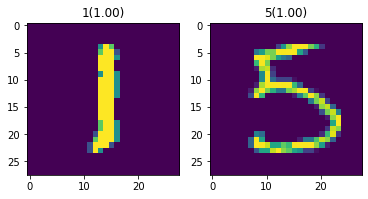

In [10]:
test_iterator = iter(test_loader)
images, labels = test_iterator.next()
# send it to gpu if available
if use_cuda:
    images = images.cuda()
    labels = labels.cuda()
# get predictions
predictions = F.softmax(model(images), dim=1).squeeze()
probs , outs = predictions.topk(1, dim=1)

# get random images from bacth
random_idx = np.random.randint(batch_size)
if use_cuda:
    image1 = images[random_idx].cpu().detach().numpy().squeeze()
    image2 = images[(random_idx+1)%batch_size].cpu().detach().numpy().squeeze()
else : 
    image1 = images[random_idx].numpy().squeeze()
    image2 = images[(random_idx+1)%batch_size].numpy().squeeze()    

prob1 = probs[random_idx, 0]. item()
out1 = outs[random_idx, 0]. item()
prob2 = probs[(random_idx+1)%batch_size, 0]. item()
out2 = outs[(random_idx+1)%batch_size, 0]. item()

# visualise results
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image1)
axs[0].set_title('{}({:.2f})'.format(out1,prob1))
axs[1].imshow(image2)
axs[1].set_title('{}({:.2f})'.format(out2,prob2))

# **Detect numbers in larger images**

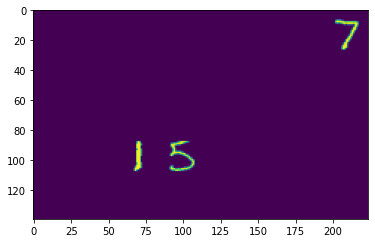

In [11]:
first_tensor = images[random_idx]
second_tensor = images[(random_idx+1)%batch_size]
third_tensor = images[(random_idx+2)%batch_size]

black_tensor = torch.zeros_like(first_tensor)

tmp_0 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, third_tensor), 2)
tmp_1 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)
tmp_2 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)

tmp_3 = torch.cat((black_tensor, black_tensor,first_tensor, second_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)
tmp_4 = torch.cat((black_tensor, black_tensor, black_tensor, black_tensor,
                   black_tensor, black_tensor, black_tensor, black_tensor), 2)

test_image = torch.cat((tmp_0, tmp_1, tmp_2, tmp_3, tmp_4), 1)

if use_cuda:
    test_image_numpy = test_image.cpu().numpy().squeeze()
else : 
    test_image_numpy = test_image.numpy().squeeze()
    
plt.imshow(test_image_numpy)

In [26]:
# get predicted labels and score
prediction = F.softmax(model(test_image.unsqueeze(dim=0)))
values, indices = prediction.squeeze().max(0)
# get the shape
values.shape, indices.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


(torch.Size([29, 50]), torch.Size([29, 50]))

In [0]:
if use_cuda:
    # score
    values = values.cpu().detach().numpy()
    # labels
    indices = indices.cpu().detach().numpy()
else :
    values = values.detach().numpy()
    indices = indices.detach().numpy()

In [0]:
# let's define our confidence level
CONFIDENCE_LEVEL = 0.99 

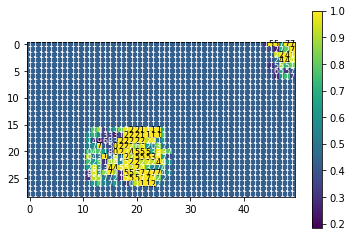

In [30]:
plt.imshow(values)
plt.colorbar()
height, width = indices.shape
for y in range(height):
        for x in range(width):
            val = indices[y, x]
            plt.annotate(str(val), xy=(x,y),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if values[y][x]<CONFIDENCE_LEVEL else 'black')

Now let's write a function that maps each output cell to a 28x28 frame in the input, let's define each frame with (y, x, y_witdth, x_width)
The first cell in the (29, 50) output which is (0, 0) corresponds to (0, 0, 28, 28) box in the input. The second cell (0, 1) corresponds to (0, 4, 28, 28) box, in other words the step is 4.

In [0]:
def extract_boxes(image, step, sub_size_x=28, sub_size_y=28):
    height, width = image.shape[0], image.shape[1]
    nb_slides_x = (width-sub_size_x)//step + 1
    nb_slides_y = (height-sub_size_y)//step + 1
    location_boxes = []
    for y in range(nb_slides_y):
        for x in range(nb_slides_x):
            location_boxes.append([y*step, x*step, sub_size_y, sub_size_x])
    return np.array(location_boxes)

In [0]:
location_boxes = extract_boxes(test_image_numpy, step=4)

In [33]:
len(location_boxes)

1450

In [34]:
len(values.flatten())

1450

As you can see the number of bounding boxes corresponds to the number of cells in the output.

In [0]:
# keep cells which activates more than the confidence level
indexes_to_keep = np.where(values.flatten() > CONFIDENCE_LEVEL)[0]
# These are the confidences and bounding boxes we want to keep for the detection
confident_scores = values.flatten()[indexes_to_keep]
confident_boxes = location_boxes[indexes_to_keep]
confident_labels = indices.flatten()[indexes_to_keep]

In [0]:
def draw_predictions(image, confident_boxes):
    for y, x, box_size_y, box_size_x in confident_boxes:
        image = cv2.rectangle(image,(x,y),(x+box_size_x,y+box_size_y),(255,0,0),1)
    return image

Let's draw the most confident boxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


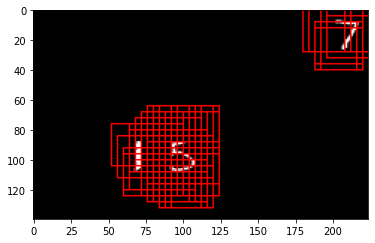

In [37]:
test_image_with_boxes = cv2.cvtColor(test_image_numpy.copy(), cv2.COLOR_GRAY2BGR)
test_image_with_boxes = draw_predictions(test_image_with_boxes, confident_boxes)
plt.imshow(test_image_with_boxes);

In [0]:
def expansion(bounding_boxes, slide_x = 1, slide_y=1):
    nb_boxes = len(bounding_boxes)   
    idx = 0
    while idx < nb_boxes-1:
        y1, x1, box_size_y1, box_size_x1 = bounding_boxes[idx]
        y2, x2, box_size_y2, box_size_x2 = bounding_boxes[idx+1]      
        if (((x1 + box_size_x1 + slide_x >= x2) or (x2 + box_size_x2 + slide_x >= x1))
            and (y1 + box_size_y1 + slide_y >= y2)):
            x = min(x1, x2)
            y = min(y1, y2)
            box_size_y = max(y2+box_size_y2, y1+box_size_y1) - min(y1,y2)
            box_size_x = max(x2+box_size_x2, x1+box_size_x1) - min(x1,x2)
            bounding_boxes[idx]= np.array([y, x, box_size_y, box_size_x])
            bounding_boxes = np.delete(bounding_boxes, idx+1, axis = 0 )
            nb_boxes = len(bounding_boxes)   
        else:
            idx+=1

    return bounding_boxes
        

In [0]:
bounding_boxes = expansion(confident_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


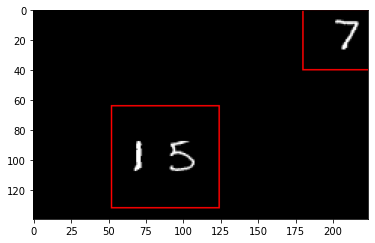

In [42]:
test_image_with_boxes = cv2.cvtColor(test_image_numpy.copy(), cv2.COLOR_GRAY2BGR)
test_image_with_boxes = draw_predictions(test_image_with_boxes, bounding_boxes)
plt.imshow(test_image_with_boxes);


Conclusion

So we've succesfully detected the numbers, but as we saw, we only used 28x28 frames to detect numbers, what if it they were bigger or very small. One solution is instead of changing the size of the frames, we can resize the input image, to make the frames bigger or smaller. We are not going to tackle this problem  and we can now easily detect the text from a given input
